Мы благодарим Юрия Агафонова за предоставленное базовое решение. К ноутбуку также предоставляется файл environment.yml (для локального запуска с помощью conda). Мы рекомендуем работать в среде Google Colab.


# Загрузка и обработка данных

In [ ]:
# рекомендуем запускать на colab: там библиотеки гарантировано встанут правильно

import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

# from utils.preprocessing import extract_log_mel_feats
# run git log чтобы посмотреть предыдущие версии кода, где не было исправлений

In [ ]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db

def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        feats = sorted(feats, key=lambda item: item["fname"])    
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })
            feats = sorted(feats, key=lambda item: item["fname"])

    pickle.dump(feats, open(out_path, 'wb'))

In [ ]:
# Если запускаете на colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Создайте на своём google drive папку sounds и загрузите туда данные с диска
# train_folder и test_folder содержат пути к этим данным

train_folder = './drive/MyDrive/sounds/audio_train/'
test_folder = './drive/MyDrive/sounds/audio_test/'

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

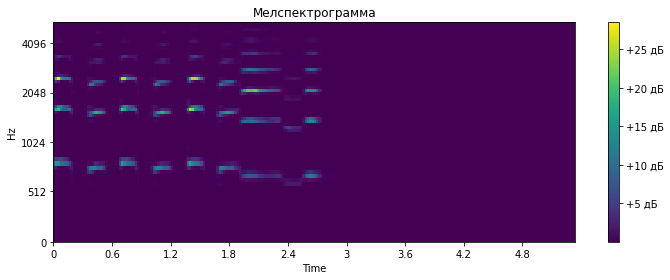

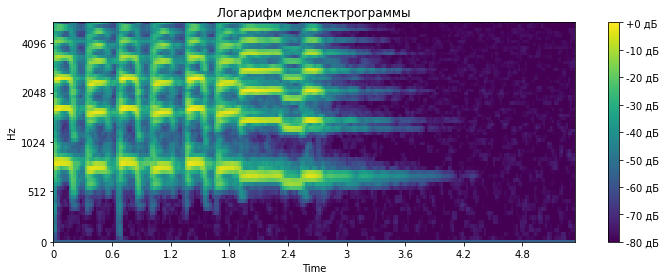

In [ ]:
# построим пример mel-спектрограммы

wav_data, sr = load(os.path.join(test_folder, '0a9f4e787d8d2af55683.wav'), sr=sample_rate)
# wav_data представляет из себя аудиоданные. Из них можно выделять разные признаки. 
# В baseline-решении мы выделяем только mel-спектрограмму


mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [ ]:
path_to_csv = os.path.join('train.csv') # Если загрузить файл прямо в colab

pickle_train_path = os.path.join('train.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]



Total files: 1869


1869it [05:22,  5.80it/s]


In [ ]:
pickle_test_path = os.path.join('test.pickle')
extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

1180it [03:05,  6.37it/s]


# Строим модель

In [ ]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch

# Модель можно менять для улучшения результата

class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        # 36864 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(36864, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [ ]:
random_input = torch.randn(1, 1, 64, 64, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

tensor([[-0.2463, -0.7177,  0.5907, -0.7337,  0.3584, -1.1719, -0.3901, -0.4678,
         -0.1071,  0.1876,  0.4957, -1.6712,  0.2973,  0.6826,  0.1117, -0.6921,
          1.0356,  0.7005, -0.6312, -2.0394, -0.1306, -0.3725,  1.3931, -0.7385,
          0.7422,  0.3492,  0.5253, -0.4092,  0.2609,  0.8406,  0.1651,  0.5123,
          1.6297, -0.2050,  0.9533, -0.7377, -0.0032, -1.1201,  1.2960,  1.3952,
         -1.0683]], grad_fn=<AddmmBackward0>)


In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
optimizer.step() 

4.06454610824585


# Загружаем данные и обучаем модель

In [ ]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [ ]:
# Это функция предобработки mel-массива. Её можно менять для улучшения результата

def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [ ]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [ ]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [ ]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

6


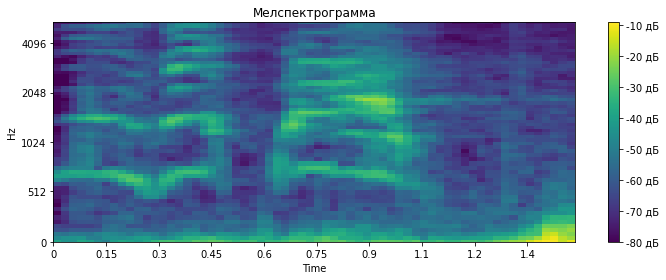

In [ ]:
sample_x, sample_y = val_dset[2]
print(sample_y)
# print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

### Собственно, обучение

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# Тут тоже можете менять всякие вещи, если хотите

n_epoch = 20
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = f1_score(y_true, y_pred, average='macro')
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train f1:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = f1_score(y_true, y_pred, average='macro')
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val f1:', acc)

epoch # 0
mean train loss: 2.947429149239152
train f1: 0.1173873562056412
mean val loss: 10.52439923286438
val f1: 0.043044516459150604
epoch # 1
mean train loss: 2.4706593222088284
train f1: 0.3929623604915826
mean val loss: 4.449640619754791
val f1: 0.13720937288091645
epoch # 2
mean train loss: 1.7095040215386286
train f1: 0.5032720707681728
mean val loss: 9.963688921928405
val f1: 0.07093004513217278
epoch # 3
mean train loss: 1.8929321611369099
train f1: 0.5206955230460076
mean val loss: 6.754112720489502
val f1: 0.07308634931842205
epoch # 4
mean train loss: 1.5493874858926844
train f1: 0.5648378948551397
mean val loss: 4.52788393497467
val f1: 0.17703245664105038
epoch # 5
mean train loss: 1.3167002245231911
train f1: 0.5920319519732662
mean val loss: 3.2510867595672606
val f1: 0.3124843087065891
epoch # 6
mean train loss: 1.1774862828078094
train f1: 0.627281668598679
mean val loss: 3.0202648758888246
val f1: 0.30140547898567865
epoch # 7
mean train loss: 1.1293518548762356
tra

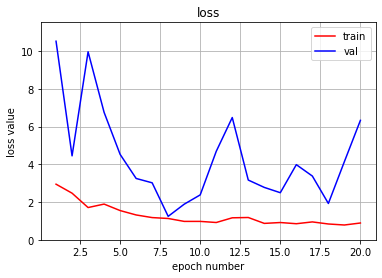

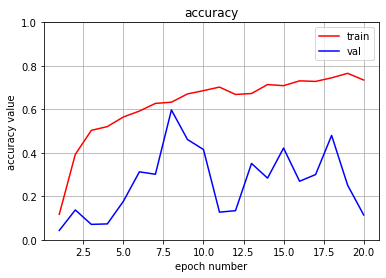

In [ ]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

# Создадим файл с предсказаниями для сдачи в контест

In [ ]:
pickle_test_data = pickle.load(open(pickle_test_path, 'rb'))

In [ ]:
x_test = []

for i, row in enumerate(pickle_test_data):
    feature = prepare_shape(row['feature'])
    x_test.append(feature)

x_test = np.asarray(x_test)

In [ ]:
test_filenames = [row['fname'] for row in pickle_test_data]

In [ ]:
test_dset = EventDetectionDataset(x_test)
test_loader = DataLoader(test_dset, batch_size=41, shuffle=False, num_workers=0)

In [ ]:
# применяем модель
outputs = []

with torch.no_grad():
    for i_batch, x in enumerate(test_loader):

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
        
    y_pred = np.hstack(outputs)

In [ ]:
# создаём датафрейм с ответами
answers = [id_to_label[item] for item in y_pred]
answer_df = pd.DataFrame({"fname": test_filenames, "label": answers})
answer_df

,fname,label
0,00879346de5cbc027e21.wav,Fart
1,012e93a3dda0d68753fc.wav,Fart
2,013415d0f64b191ac89c.wav,Fart
3,014ab2afdf1fd15bb17d.wav,Fart
4,015ee13ed41cc6d11c91.wav,Fart
...,...,...
1175,ff1a5bfca0505dca23a9.wav,Fart
1176,ff76047a36776caf21b8.wav,Fart
1177,ffddcd95543e6318fc92.wav,Fart
1178,fff232dd35909fd26a59.wav,Fart


In [ ]:
# считываем порядок, в котором должны идти ответы
test_filenames_ori = pd.read_csv("test_filenames.csv")
test_filenames_ori.head()

,fname
0,00879346de5cbc027e21.wav
1,012e93a3dda0d68753fc.wav
2,013415d0f64b191ac89c.wav
3,014ab2afdf1fd15bb17d.wav
4,015ee13ed41cc6d11c91.wav


In [ ]:
# сортируем ответы алгоритма в нужном порядке
answer_df_ori = test_filenames_ori.merge(answer_df, on='fname')
answer_df_ori.head()

,fname,label
0,00879346de5cbc027e21.wav,Fart
1,012e93a3dda0d68753fc.wav,Fart
2,013415d0f64b191ac89c.wav,Fart
3,014ab2afdf1fd15bb17d.wav,Fart
4,015ee13ed41cc6d11c91.wav,Fart


In [ ]:
#создаём submission
answer_df_ori.to_csv("submission.csv", index=None)